<a href="https://colab.research.google.com/github/Corry-Grodek/DataScience/blob/main/Copy_of_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [ ]:
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
cs_data = pd.read_csv(url_cs)

diff_TminusE = cs_data.theo - cs_data.exp

cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)

aa_encode = pd.Categorical(cs_data['aa'])
aa_idx = aa_encode.codes
aa_coords = {"aa": aa_encode.categories}
aa_coords

{'aa': Index(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
        'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'],
       dtype='object')}

In [ ]:
#NORMAL MODEL

with pm.Model(coords=aa_coords) as cs_hn_model:
  #no dims means priors are shared
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    #use hyperpriors
    μ = pm.Normal('μ', mu = μ_mu, sigma = μ_sd, dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,  dims = "aa")

    #likelihood
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_hn = pm.sample()

Output()

Output()

In [ ]:
#STUDENT T MODEL

with pm.Model(coords=aa_coords) as cs_ht_model:
   #no dims means priors are shared
    μ_mu = pm.StudentT('μ_mu', nu = 1, mu = 0,sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)


    #use hyperpriors
    μ = pm.StudentT('μ',  mu = μ_mu, nu = 1, sigma = μ_sd, dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10, dims = "aa")

    ν = pm.Exponential('ν',lam =.5, dims = 'aa')

    #likelihood
    y = pm.StudentT('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  nu = ν[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_ht = pm.sample()

Output()

Output()

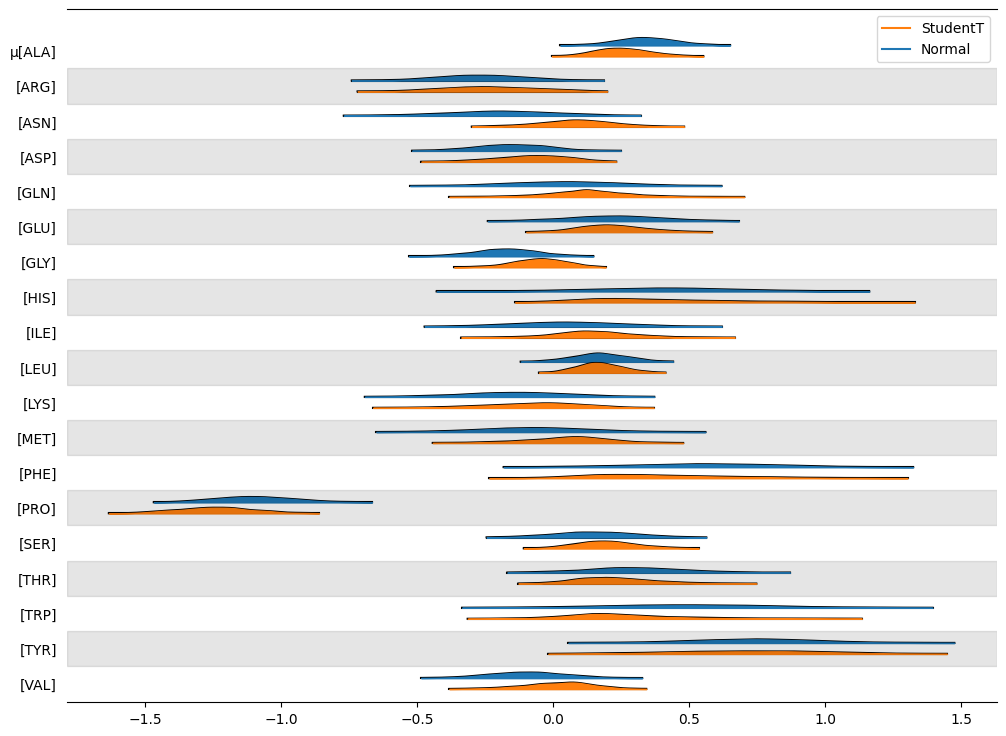

In [ ]:
axes = az.plot_forest([idata_cs_hn, idata_cs_ht],
                      kind="ridgeplot",
                      var_names='μ',
                      model_names=['Normal','StudentT'],
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

Output()

Output()

(-10.0, 10.0)

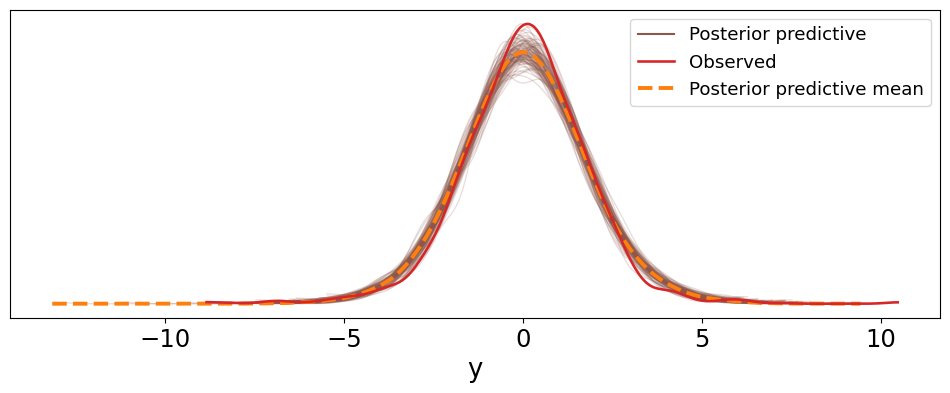

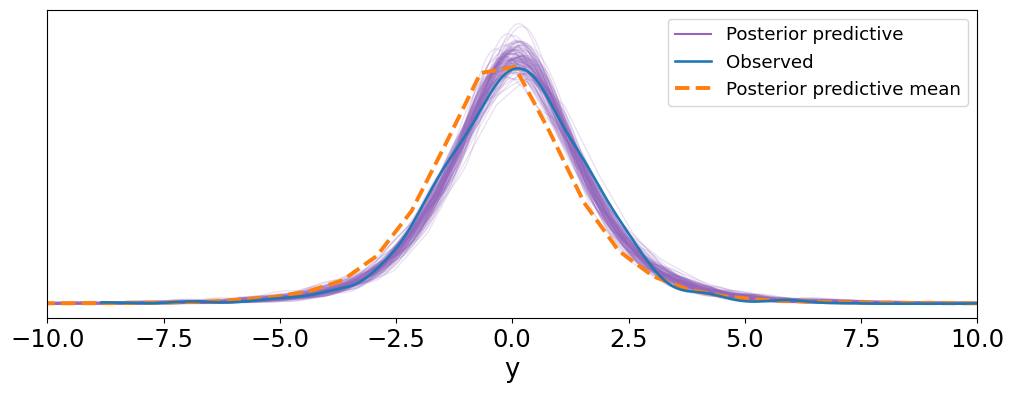

In [ ]:
pm.sample_posterior_predictive(idata_cs_hn, model=cs_hn_model, extend_inferencedata=True)
pm.sample_posterior_predictive(idata_cs_ht, model=cs_ht_model, extend_inferencedata=True)
ax  = az.plot_ppc(data=idata_cs_hn, num_pp_samples=100, figsize=(12, 4), colors=["C5", "C3", "C1"]) #Normal
ax1 = az.plot_ppc(data=idata_cs_ht, num_pp_samples=100, figsize=(12, 4), colors=["C4", "C0", "C1"]) #StudentT
ax1.set_xlim(-10, 10)

**The Normal model is closer to the observed data than the StudentT model. The StudentT model is more true to the shape of the curve but is offset.**

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [ ]:
#load the data from my github page.
#sccr stands for soccer
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})


#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

sccr_data

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [ ]:
with pm.Model(coords = sccr_coords) as sccr_model:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20, dims = "pos")
    ν = pm.Gamma('ν', mu = 55, sigma = 45, dims = "pos")


    # Parameter for players
    θ = pm.Beta('θ', mu = μ[pos_idx], nu = ν[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.0 1.001 1.004 1.001 ... 1.001 1.002 1.0
    μ        (pos) float64 32B 1.0 1.001 1.012 1.001
    ν        (pos) float64 32B 1.037 1.003 1.027 1.013

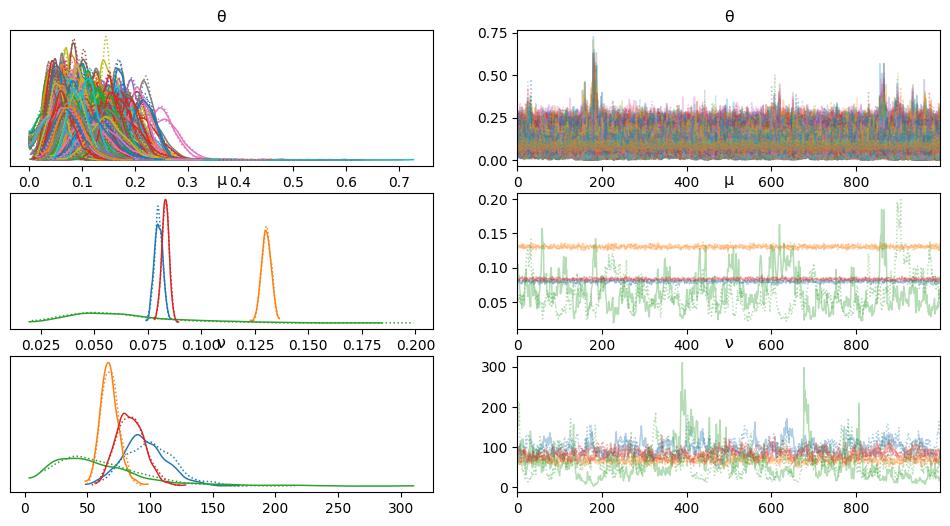

In [ ]:
az.plot_trace(idata_sccr)
az.rhat(idata_sccr)

**The R-hat values for theta, mu, and nu are all higher for the non-hierarchical model than the R-hat values for the hierarchical model.**

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

Output()

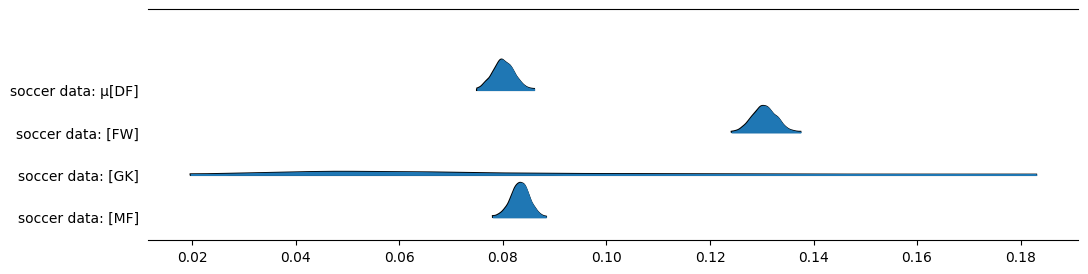

In [ ]:
pm.sample_posterior_predictive(idata_sccr, model=sccr_model, extend_inferencedata=True)
axes = az.plot_forest([idata_sccr],
                      kind="ridgeplot",
                      var_names='μ',
                      model_names=['soccer data'],
                      combined=True, figsize=(12, 3), hdi_prob=0.997)

**The posterior data is pretty much identical to the hierarchical model.**

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [ ]:
nonGK = sccr_data.query('position != "GK"')
nonGK

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [ ]:

#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = nonGK.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = nonGK.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = nonGK.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = nonGK.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}



In [ ]:
with pm.Model(coords = sccr_coords) as sccr_modelGK:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = nonGK.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = nonGK.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccrGK = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 1.0 1.001 1.005 1.001 ... 0.9994 0.9995 1.0
    μ        float64 8B 1.004
    μ_p      (pos) float64 32B 1.004 1.003 1.003 1.01
    ν        float64 8B 1.001
    ν_p      (pos) float64 32B 1.015 0.9997 1.001 1.014

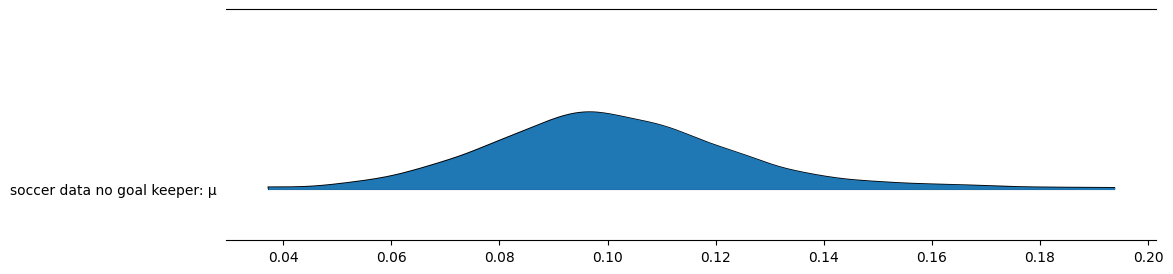

In [ ]:
pm.sample_posterior_predictive(idata_sccrGK, model=sccr_modelGK, extend_inferencedata=True)
axes = az.plot_forest([idata_sccrGK],
                      kind="ridgeplot",
                      var_names='μ',
                      model_names=['Soccer data no GK'],
                      combined=True, figsize=(12, 3), hdi_prob=0.997)
az.rhat(idata_sccrGK)

**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

**The model without the goal keeper data was easier to proccess (took a quarter as long to run). By dropping the GK data we can be more specific with what data we want to create our model with, making a more relavent model. The goal keepers score to miss ratio was not relavent for anything we want to learn about how differnt positions score.**